In [7]:
%matplotlib widget

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jaxgym.stemoverfocus import project_frame_backward
import json
import tqdm.auto as tqdm
import jaxgym.components as comp

jax.config.update('jax_platform_name', 'cpu')

Load the Data

In [9]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape']
det_shape = params_dict['det_shape']
scan_step_yx = params_dict['scan_step_yx']
det_px_size = params_dict['det_px_size']
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']

Make the model

In [10]:
#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), 
                         scan_step_yx=params_dict['scan_step_yx'], 
                         scan_shape_yx=params_dict['scan_shape'], 
                         scan_rotation=params_dict['scan_rotation'])

Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), 
                           descan_error=params_dict['descan_error'], 
                           offset_x=0., 
                           offset_y=0.)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), det_shape_yx=params_dict['det_shape'], det_pixel_size_yx=params_dict['det_px_size'])
model = [PointSource, ScanGrid, Descanner, Detector]

Generate the backward get_shifted_sum solution

In [11]:
shifted_sum = np.zeros(ScanGrid.scan_shape_yx, dtype=np.complex64)
scan_coords_yx = ScanGrid.coords.reshape(*ScanGrid.scan_shape_yx, 2)

for y_idx in tqdm.trange(fourdstem_array.shape[0], desc='Scan Y'):
    for x_idx in range(fourdstem_array.shape[1]):
        scan_pos = scan_coords_yx[y_idx, x_idx]
        
        # Compute the backward projection for this scan position.
        shifted_sum += project_frame_backward(model, fourdstem_array[y_idx, x_idx], scan_pos)


Scan Y:   0%|          | 0/103 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Shifted Sum Image')

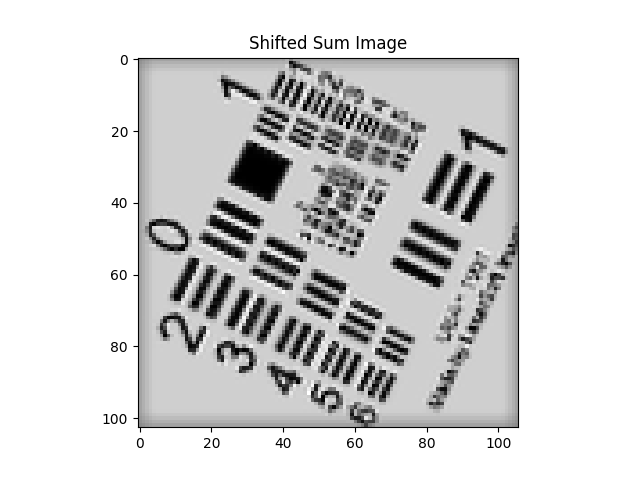

In [12]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')